# Import libraries

In [1]:
import os
import zipfile
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
with zipfile.ZipFile('../input/facial-keypoints-detection/training.zip', 'r') as zip_ref:
    zip_ref.extractall('train')
    
with zipfile.ZipFile('../input/facial-keypoints-detection/test.zip', 'r') as zip_ref:
    zip_ref.extractall('test')
    

# Load Dataset

In [3]:
train_data = 'train/training.csv'
test_data = 'test/test.csv'
lookid_data = '../input/facial-keypoints-detection/IdLookupTable.csv'

train_df = pd.read_csv(train_data)
test_df = pd.read_csv(test_data)
lookid_df = pd.read_csv(lookid_data)


# Data Analysis

In [4]:
print(len(train_df))

train_df.head(10).T

7049


,0,1,2,3,4,5,6,7,8,9
left_eye_center_x,66.0336,64.3329,65.0571,65.2257,66.7253,69.6807,64.1319,67.4689,65.8029,64.1212
left_eye_center_y,39.0023,34.9701,34.9096,37.2618,39.6213,39.9687,34.29,39.4135,34.7552,36.7403
right_eye_center_x,30.227,29.9493,30.9038,32.0231,32.2448,29.1836,29.579,29.356,27.4758,29.4689
right_eye_center_y,36.4217,33.4487,34.9096,37.2618,38.042,37.5634,33.138,39.6217,36.1856,38.3902
left_eye_inner_corner_x,59.5821,58.8562,59.412,60.0033,58.5659,62.8643,57.7972,59.555,58.6522,58.6209
left_eye_inner_corner_y,39.6474,35.2743,36.321,39.1272,39.6213,40.1693,35.154,40.4548,37.3293,37.8406
left_eye_outer_corner_x,73.1303,70.7227,70.9844,72.3147,72.5159,76.8982,69.0266,75.5916,72.953,71.272
left_eye_outer_corner_y,39.97,36.1872,36.321,38.381,39.8845,41.1719,34.29,40.0382,35.8995,37.2903
right_eye_inner_corner_x,36.3566,36.0347,37.6781,37.6186,36.9824,36.401,34.7617,37.4782,36.3424,36.3446
right_eye_inner_corner_y,37.3894,34.3615,36.321,38.7541,39.0949,39.3676,33.714,40.4548,37.0432,39.4905


In [5]:
print(train_df.isnull().values.ravel().sum())
print(len(train_df.dropna()))
train_df.fillna(method= 'ffill', inplace= True)

105412
2140


In [6]:
print(len(test_df))
print(test_df.isnull().values.ravel().sum())
test_df.head(10)

1783
0


,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...
5,6,177 177 177 171 142 115 97 84 89 90 88 82 63 5...
6,7,77 55 44 56 58 61 67 66 65 65 65 73 72 78 86 9...
7,8,156 160 162 166 150 114 97 105 125 127 119 121...
8,9,230 230 231 231 231 231 231 231 231 229 214 20...
9,10,132 129 126 128 146 163 170 169 143 101 71 55 ...


## Prepare Training Data

In [7]:

train_data = []

for image in train_df['Image'].values:
    img = image.split(' ')
    image_array = [0 if '' == img[i] else img[i] for i in range(len(img))]
    train_data.append(image_array)
    



train_data = np.asarray(train_data, np.float32)
train_data = train_data.reshape(-1, 96, 96, 1)
print(train_data.shape)



(7049, 96, 96, 1)


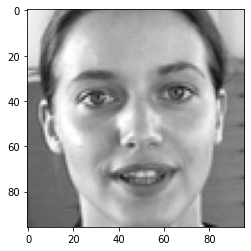

In [8]:
image = train_data[20]
plt.imshow(image.reshape(96, 96), cmap='gray')

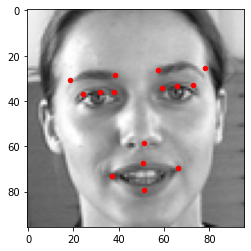

In [9]:
train_labels = train_df.drop('Image', axis= 1).to_numpy(dtype= np.float32)
plt.imshow(train_data[20].reshape(96, 96), cmap= 'gray')
plt.scatter(train_labels[20][0::2], train_labels[100][1::2], marker='o',color= 'red', s=20)

# Data Preprocessing

## 1. Histogram Equilization

In [10]:
# eq_image_list = []
# eq_keypoint_list = []
# for i in range(7049):
#     eq_image = cv2.equalizeHist(train_data[i].reshape(96, 96))
#     eq_image_list.append(eq_image)
#     eq_keypoint_list.append(train_labels[i])
    
# train_data = np.concatenate((train_data, np.asarray(eq_image_list, np.float32)), axis= 0)
# train_labels = np.concatenate((train_labels, np.asarray(eq_keypoint_list, np.float32)), axis= 0)
# print(train_data.shape)
# print(train_labels.shape)


## 2. Data Augmentation by Horizontal Flipping

In [11]:
def horizontal_flip(image, keypoint):
    flipped_image = np.flip(image, axis= 1)
    flipped_keypoint = [(image.shape[0] - keypoint[i]) if (i % 2 == 0) else keypoint[i] for i in range(len(keypoint))]
    return flipped_image, np.asarray(flipped_keypoint, dtype= np.float32)

flipped_image_list = []
flipped_keypoint_list = []
for i in range(train_data.shape[0]):
    flipped_image, flipped_keypoint = horizontal_flip(train_data[i], train_labels[i])
    flipped_image_list.append(flipped_image)
    flipped_keypoint_list.append(flipped_keypoint)
    


    

In [12]:
# train_labels.shape
print(np.array(flipped_keypoint_list).shape)

(7049, 30)


In [13]:
train_data = np.concatenate((train_data, flipped_image_list), axis= 0)
train_labels = np.concatenate((train_labels, np.asarray(flipped_keypoint_list, np.float32)), axis= 0)
print(train_data.shape)
print(train_labels.shape)

(14098, 96, 96, 1)
(14098, 30)


# Prepare Test Data

In [14]:
test_df.isnull().values.ravel().sum()
test_data = []
for image in test_df['Image'].to_numpy():
    img = image.split(' ')
    image_array = [0 if img[i] == '' else img[i] for i in range(len(img))]
    test_data.append(image_array)


test_data = np.asarray(test_data, np.float32)
test_data = train_data.reshape(-1, 96, 96, 1)
test_data.shape


(14098, 96, 96, 1)

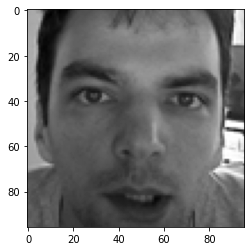

In [15]:
img = test_data[5]
plt.imshow(img.reshape(96, 96), cmap= 'gray')

# Build Model

In [24]:
import tensorflow as tf
import keras

model = keras.Sequential(
[
    keras.layers.Conv2D(32, (3, 3), padding= 'same', use_bias=False, input_shape= (96, 96, 1)),
    keras.layers.LeakyReLU(alpha= 0.1),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.BatchNormalization(), 
     
    
    keras.layers.Conv2D(64, (3, 3), padding= 'same', use_bias=False),
    keras.layers.LeakyReLU(alpha= 0.1),
    keras.layers.BatchNormalization(), 
    
    keras.layers.Conv2D(64, (3, 3), padding= 'same', use_bias=False),
    keras.layers.LeakyReLU(alpha= 0.1),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.BatchNormalization(), 
    
    keras.layers.Conv2D(128, (3, 3), padding= 'same', use_bias=False),
    keras.layers.LeakyReLU(alpha= 0.1),
    keras.layers.BatchNormalization(), 
    
    keras.layers.Conv2D(128, (3, 3), padding= 'same', use_bias=False),
    keras.layers.LeakyReLU(alpha= 0.1),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.BatchNormalization(), 
    
    keras.layers.Conv2D(256, (3, 3), padding= 'same', use_bias=False),
    keras.layers.LeakyReLU(alpha= 0.1),
    keras.layers.BatchNormalization(), 
    
    keras.layers.Conv2D(256, (3, 3), padding= 'same', use_bias=False),
    keras.layers.LeakyReLU(alpha= 0.1),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.BatchNormalization(), 
     
    
    keras.layers.Conv2D(512, (3, 3), padding= 'same', use_bias=False),
    keras.layers.LeakyReLU(alpha= 0.1),
    keras.layers.BatchNormalization(), 
    
    keras.layers.Conv2D(512, (3, 3), padding= 'same', use_bias=False),
    keras.layers.LeakyReLU(alpha= 0.1),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.BatchNormalization(),
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(256, activation= 'relu'),
    keras.layers.Dropout(0.2),
    

    
        
    keras.layers.Dense(30),
    
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 48, 48, 64)        18432     
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 48, 48, 64)        0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 48, 48, 64)       

# Compile Model

In [25]:
model.compile(
    optimizer= 'adam',
    loss = 'mean_squared_error',
    metrics = ['mae'],
             )

In [26]:
print(train_data.shape)
print(type(train_data))
print(train_labels.shape)
print(type(train_labels))

print(test_data.shape)
print(type(test_data))


(14098, 96, 96, 1)
<class 'numpy.ndarray'>
(14098, 30)
<class 'numpy.ndarray'>
(14098, 96, 96, 1)
<class 'numpy.ndarray'>


# Train Model

In [27]:
history = model.fit(
    train_data,
    train_labels,
    epochs= 100,
    validation_split= 0.2,
    batch_size= 128,
)

Epoch 1/100
89/89 [==============================] - 6s 69ms/step - loss: 322.9511 - mae: 12.8447 - val_loss: 439.9757 - val_mae: 16.6071
Epoch 2/100
89/89 [==============================] - 6s 66ms/step - loss: 192.9284 - mae: 9.9381 - val_loss: 370.2885 - val_mae: 14.3260
Epoch 3/100
89/89 [==============================] - 6s 66ms/step - loss: 166.4639 - mae: 8.8909 - val_loss: 296.7944 - val_mae: 12.7550
Epoch 4/100
89/89 [==============================] - 6s 66ms/step - loss: 147.1496 - mae: 8.1317 - val_loss: 189.1584 - val_mae: 9.5303
Epoch 5/100
89/89 [==============================] - 6s 66ms/step - loss: 136.7310 - mae: 7.7106 - val_loss: 289.8657 - val_mae: 10.4719
Epoch 6/100
89/89 [==============================] - 6s 66ms/step - loss: 124.7332 - mae: 7.2193 - val_loss: 376.2564 - val_mae: 11.8955
Epoch 7/100
89/89 [==============================] - 6s 65ms/step - loss: 115.3129 - mae: 6.8753 - val_loss: 337.0408 - val_mae: 11.6965
Epoch 8/100
89/89 [======================

89/89 [==============================] - 6s 65ms/step - loss: 52.4909 - mae: 4.2451 - val_loss: 378.5984 - val_mae: 10.6711
Epoch 62/100
89/89 [==============================] - 6s 65ms/step - loss: 29.1570 - mae: 3.4589 - val_loss: 349.6122 - val_mae: 9.9294
Epoch 63/100
89/89 [==============================] - 6s 65ms/step - loss: 27.0046 - mae: 3.4403 - val_loss: 321.4790 - val_mae: 9.3698
Epoch 64/100
89/89 [==============================] - 6s 65ms/step - loss: 22.9316 - mae: 3.2407 - val_loss: 366.3997 - val_mae: 10.0750
Epoch 65/100
89/89 [==============================] - 6s 65ms/step - loss: 17.1953 - mae: 3.0450 - val_loss: 408.7443 - val_mae: 11.0248
Epoch 66/100
89/89 [==============================] - 6s 65ms/step - loss: 15.5912 - mae: 2.9450 - val_loss: 291.7717 - val_mae: 9.0844
Epoch 67/100
89/89 [==============================] - 6s 66ms/step - loss: 15.6820 - mae: 2.9763 - val_loss: 379.0653 - val_mae: 10.1469
Epoch 68/100
89/89 [==============================] - 6s 

# Graph Visualization

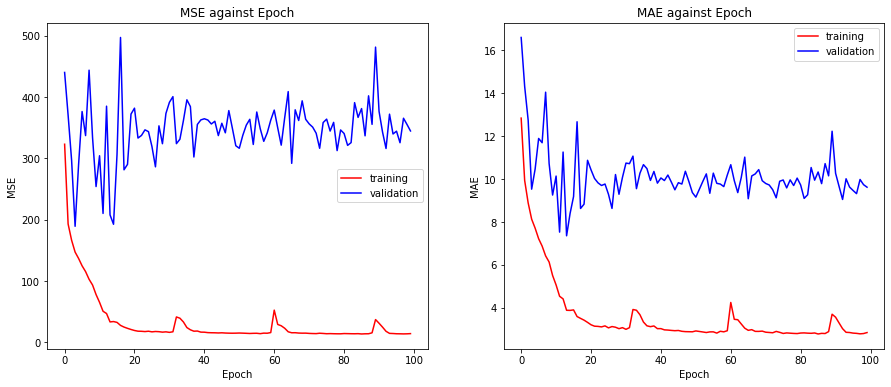

In [28]:
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']
epoch = range(len(loss))

fig, ((ax1,ax2)) = plt.subplots(1, 2,figsize=(15,6), sharex=True, sharey=False)

ax1.plot(epoch, loss, 'r', label= 'training')
ax1.plot(epoch, val_loss, 'b', label= 'validation')
ax1.set_title('MSE against Epoch')
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE')

ax2.plot(epoch, mae, 'r', label= 'training')
ax2.plot(epoch, val_mae, 'b', label= 'validation')
ax2.set_title('MAE against Epoch')
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MAE')

fig.savefig('graph.png')


# Prediction on Test Data

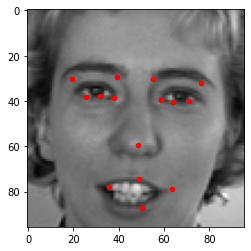

In [41]:
p = model.predict(test_data)

plt.imshow(test_data[410].reshape(96, 96), cmap= 'gray')
plt.scatter(p[430][::2], p[410][1::2], marker='o',color= 'red', s=20)

In [34]:
print(p.shape)

(14098, 30)


In [42]:
pred = model.predict(test_data)

In [43]:
pred.shape

(14098, 30)

# Preparing for Submission

In [44]:
lookid_list = list(lookid_df['FeatureName'])
imageID = list(lookid_df['ImageId']-1)
pre_list = list(pred)

rowid = lookid_df['RowId']
rowid=list(rowid)

In [45]:
feature = []
for f in list(lookid_df['FeatureName']):
    feature.append(lookid_list.index(f))


In [46]:
preded = []
for x,y in zip(imageID,feature):
    preded.append(pre_list[x][y])

In [48]:
rowid = pd.Series(rowid,name = 'RowId')
loc = pd.Series(preded,name = 'Location')
submission = pd.concat([rowid,loc],axis = 1)
submission.to_csv('face_key_detection_submission_.csv',index = False)